In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataloader import *
from utils import *
from models.CNN import CNNForecaster

device = "cuda:0" if torch.cuda.is_available() else "cpu"

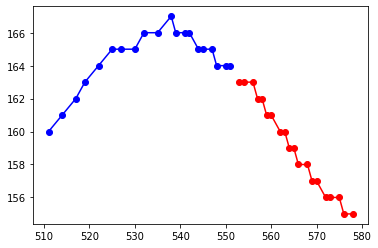

In [17]:
# Load the data
path = 'data/box_training_data/'
x_train = np.load(path + 'x_train.npy').astype(np.float32)
y_train = np.load(path + 'y_train.npy').astype(np.float32)
x_test = np.load(path + 'x_test.npy').astype(np.float32)
y_test = np.load(path + 'y_test.npy').astype(np.float32)

x_sample, y_sample = x_train[0], y_train[0]
plt.plot(x_sample[0], x_sample[1], 'bo-')
plt.plot(y_sample[0], y_sample[1], 'ro-')
plt.show()

In [18]:
"""
Create dataloaders for training and testing with batch size 32
"""

class ForecastDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
def create_dataloader(features, labels, batch_size=1):
    train_ds = ForecastDataset(features, labels)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    return train_dl

train_dataloader = create_dataloader(x_train, y_train, batch_size=32)
test_dataloader = create_dataloader(x_test, y_test, batch_size=32)

In [19]:
def train(model, train_dataloader, test_dataloader, epochs, optimizer, criterion):
    """
    Train the model for the given number of epochs
    """
    # Keep track of training and validation loss
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        # Training
        avg_loss = 0
        for i, (x, y) in enumerate(train_dataloader):
            # Forward pass
            y_pred = model(x)
            y_pred = model.reshape_output(y_pred)
            # Compute loss
            loss = criterion(y_pred, y)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
                    
        avg_loss = avg_loss / len(test_dataloader)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs} | Loss: {avg_loss:.4f}')
        
        # Validation
        avg_loss = 0
        for i, (x, y) in enumerate(test_dataloader):
            # Forward pass
            y_pred = model(x)
            y_pred = model.reshape_output(y_pred)
            # Compute loss
            loss = criterion(y_pred, y)
            avg_loss += loss.item()
            
        avg_loss = avg_loss / len(test_dataloader)
        test_losses.append(loss.item())
        print(f'Epoch {epoch + 1}/{epochs} | Validation Loss: {avg_loss:.4f}')
    
    return train_losses, test_losses

def average_displacement_loss(y_pred, y):
    """
    Compute the average displacement loss from two tensors
    """
    def euclidean_distance(x, y):
        return torch.sqrt(torch.sum((x - y)**2))

    losses = []
    for batch in range(y_pred.shape[0]):
        distance_sum = 0
        for i in range(y_pred.shape[1]):
            distance_sum += euclidean_distance(y_pred[batch, i], y[batch, i])
        distance_sum = distance_sum / y_pred.shape[1]
        losses += [distance_sum]
    
    return torch.mean(torch.Tensor(losses))
    
def final_displacement_loss(y_pred, y):
    """
    Compute the final displacement loss from two tensors
    """
    def euclidean_distance(x, y):
        return torch.sqrt(torch.sum((x - y)**2))

    losses = []
    for batch in range(y_pred.shape[0]):
        distance = euclidean_distance(y_pred[batch, -1], y[batch, -1])
        losses += [distance]
    
    return torch.mean(torch.Tensor(losses))

model = CNNForecaster((4, 20), (4, 20), 4, 0.5, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


Epoch 1/10 | Loss: 25571.0455
Epoch 1/10 | Validation Loss: 1951.7071
Epoch 2/10 | Loss: 6378.5406
Epoch 2/10 | Validation Loss: 1436.7090
Epoch 3/10 | Loss: 5598.8667
Epoch 3/10 | Validation Loss: 1394.7567
Epoch 4/10 | Loss: 5584.0330
Epoch 4/10 | Validation Loss: 1557.9309
Epoch 5/10 | Loss: 5435.8774
Epoch 5/10 | Validation Loss: 1338.8389
Epoch 6/10 | Loss: 5342.1399
Epoch 6/10 | Validation Loss: 1274.2337
Epoch 7/10 | Loss: 5271.1647
Epoch 7/10 | Validation Loss: 1333.5917
Epoch 8/10 | Loss: 5155.5817
Epoch 8/10 | Validation Loss: 1200.9724
Epoch 9/10 | Loss: 4973.4886
Epoch 9/10 | Validation Loss: 1225.3118
Epoch 10/10 | Loss: 5088.0548
Epoch 10/10 | Validation Loss: 1238.9943


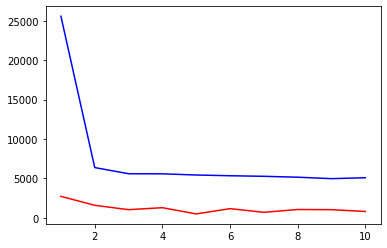

In [20]:
EPOCHS = 10

train_loss, test_loss = train(model, train_dataloader, test_dataloader, epochs=EPOCHS, optimizer=optimizer, criterion=criterion)

plt.plot(range(1, EPOCHS+1), train_loss, 'b-', label='Training Loss')
plt.plot(range(1, EPOCHS+1), test_loss, 'r-', label='Validation Loss')

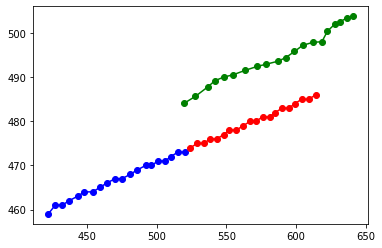

(tensor(197.5772), tensor(58.9623), tensor(31.4375))


In [26]:
def evaluate(model, x_test, y_test):
    """
    Evaluate the model on the test set
    """
    y_pred = model(x_test)
    y_pred = model.reshape_output(y_pred).detach().cpu()
    mse = criterion(y_pred, y_test)
    l1 = average_displacement_loss(y_pred, y_test)
    l2 = final_displacement_loss(y_pred, y_test)
    
    plt.plot(x_test[0][0], x_test[0][1], 'bo-')
    plt.plot(y_test[0][0], y_test[0][1], 'ro-')
    plt.plot(y_pred[0][0], y_pred[0][1], 'go-')
    plt.show()
    
    return mse, l1, l2

x_batch, y_batch = next(iter(test_dataloader))
x_sample, y_sample = x_batch[0].view(1, 4, 20), y_batch[0].view(1, 4, 20)
print(evaluate(model, x_sample, y_sample))